In [1]:
import numpy as np
import pandas as pd
import os
import re
from tqdm.notebook import tqdm, trange
from razdel import tokenize
from pymorphy2 import MorphAnalyzer

In [3]:
n_files = 0
for _dir in ['pos', 'neg', 'neu']:
    n_files += len(os.listdir(f'data\{_dir}'))

df = []
with tqdm(total = n_files) as psbar:
    for _dir in ['pos', 'neg', 'neu']:
        for file_name in os.listdir(f'data\{_dir}'):
            with open(f'data\{_dir}\{file_name}', 'r', encoding = 'UTF-8') as f:
                df.append((f.read(), _dir))
                psbar.update(1)
            
df = pd.DataFrame(df, columns = ['review', 'target'])

  0%|          | 0/131669 [00:00<?, ?it/s]

In [4]:
df['target'] = df['target'].map({'neg': 0, 'neu': 1, 'pos': 2})
df['target'] = np.array(df['target'].values, dtype = np.int8)

In [5]:
with open(r'additional_data\targets.npy', 'wb') as tr_file:
    np.save(tr_file, df['target'].values)

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
s_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\onton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def token_is_good(token, stop_words = []):
    if len(token) < 4 or len(token) > 25:
        return False
    if token in stop_words:
        return False
    if re.fullmatch(r'[А-Яа-яЁёЙй]+', token) is None:
        return False
    # Если слово содержит в себе три одинаковых символа подряд
    if re.match(r'^.*(.)(\1)(\1).*$', token) is not None:
        return False
    return True

In [9]:
morph = MorphAnalyzer()
tokenized_reviews = []
for i in trange(len(df)):
    tokenized_reviews.append([morph.parse(tok.text)[0].normal_form for tok in tokenize(df.loc[i, 'review']) if token_is_good(tok.text, s_words)])
    # Эквивалентно:
    # review = df.loc[i, 'review']
    # review = [morph.parse(tok.text)[0].normal_form for tok in tokenize(review) if token_is_good(tok.text, s_words)]
    # tokenized_reviews.append(review)
    # Дело в том, что так, как это реализовано получается быстрее примерно на 10-15 минут

  0%|          | 0/131669 [00:00<?, ?it/s]

Сформируем отображение "слово - целое число"

In [10]:
vocabulary = {'<pad>': 0}
word_ind = 1 
for rev in tqdm(tokenized_reviews):
    for word in rev:
        if word not in vocabulary:
            vocabulary[word] = word_ind
            word_ind += 1

  0%|          | 0/131669 [00:00<?, ?it/s]

In [12]:
import pickle
with open(r'additional_data\vocab.pickle', 'wb') as vocab_file:
    pickle.dump(vocabulary, vocab_file)

Посмотрим на распределение длин слов

  0%|          | 0/131669 [00:00<?, ?it/s]

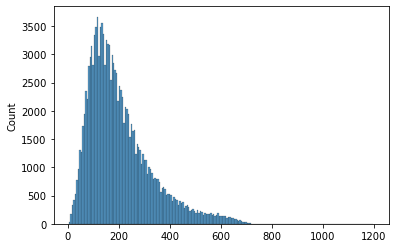

In [16]:
import seaborn as sns
_lens = []

for rev in tqdm(tokenized_reviews):
    _lens.append(len(rev))
    
sns.histplot(_lens);

In [17]:
MAX_LEN = 500

for i in trange(len(tokenized_reviews)):
    _len = len(tokenized_reviews[i])
    if _len < MAX_LEN:
        tokenized_reviews[i] = ['<pad>'] * (MAX_LEN - _len) + tokenized_reviews[i]
    else:
        # Если отзыв длинее пятиста слов, берём последние 500, ибо из житейского опыта
        # кажется, что если отзыв достаточно длинный, то отношение автора к картине 
        # раскрывается ближе к его концу
        tokenized_reviews[i] = tokenized_reviews[i][-MAX_LEN:]

  0%|          | 0/131669 [00:00<?, ?it/s]

Заменим в отзывах слова соответствующими числами

In [22]:
for i in trange(len(tokenized_reviews)):
    for j in range(len(tokenized_reviews[i])):
        tokenized_reviews[i][j] = vocabulary[tokenized_reviews[i][j]]

  0%|          | 0/131669 [00:00<?, ?it/s]

In [28]:
with open(r'additional_data\vocab_tokenized_reviews.pickle', 'wb') as tr_file:
    pickle.dump(tokenized_reviews, tr_file)